In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
import pandas_profiling
import eli5
import re
import pickle
from sklearn.model_selection import train_test_split

from pandarallel import pandarallel
import gbm_model

from pandarallel import pandarallel



In [2]:
pandarallel.initialize()
pd.set_option('display.max_colwidth', None)
sns.set_style('darkgrid')
RANDOM_STATE = 42

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
df_small = pd.read_csv('data/urls.csv')
df_big = pd.read_csv('data/data.csv')
df = pd.concat([df_small, df_big], axis=0)

df.reset_index(drop=True, inplace=True)
df['label'] = df['label'].parallel_apply(lambda label: 1 if (label == 'Unsafe') or (label == 'bad') else 0)
df, level0_text  = train_test_split(df,
                                    random_state = RANDOM_STATE,
                                    test_size = 0.15,
                                    stratify=df['label'])
df.reset_index(drop=True, inplace=True)
level0_text.reset_index(drop=True, inplace=True)
df.to_csv('data/big.csv', index=False)
level0_text.to_csv('data/level0.csv', index=False)

In [4]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = gbm_model.preprocess(df, is_fitted = False)

In [5]:
gbm = CatBoostClassifier(task_type="GPU", logging_level='Silent', 
                         loss_function='Logloss', od_type='Iter')
cv_results = gbm_model.get_cross_val(gbm, train_data, train_labels)
print(cv_results)

[0.98472944 0.98609194 0.985992   0.98546211 0.9865051 ]


roc_auc:  0.9890804327023974
f1:  0.9138638228055783


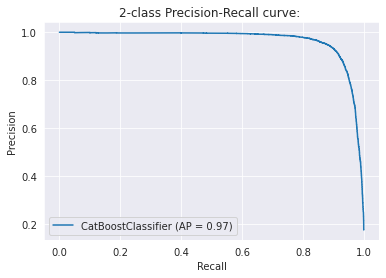

In [6]:
gbm = gbm_model.train_gbm(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [7]:
eli5.explain_weights_catboost(gbm, vec=None, top=20, importance_type='PredictionValuesChange', feature_names=None, pool=None)

Weight,Feature
0.1123,path_len
0.0562,7
0.0499,4
0.0432,0
0.0389,39
0.0329,1
0.0274,path_nums
0.0251,14
0.0246,33
0.0239,18
